In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# importing the previously generated merged_df with Traders_df and Sentiment_df

import os
import pickle
import pandas as pd

root_dir = "/content/drive/MyDrive/ds_madhulika_chandel/csv_files"
output_dir = "/content/drive/MyDrive/ds_madhulika_chandel/outputs"

merged_df = pd.read_pickle(os.path.join(root_dir, "merged_df.pkl"))

In [ ]:
print(merged_df.shape)
print(merged_df.columns)
merged_df.head()

(211218, 24)
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date', 'classification', 'value', 'Account_Simple',
       'ExecutionPrice_log', 'Execution Price Capped', 'PriceGroup',
       'SizeUSD_log'],
      dtype='object')


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Trade ID,Timestamp,date,classification,value,Account_Simple,ExecutionPrice_log,Execution Price Capped,PriceGroup,SizeUSD_log
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed,80.0,User1,2.194655,7.9769,Low-Price,8.971215
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed,80.0,User1,2.195000,7.9800,Low-Price,4.857329
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed,80.0,User1,2.195612,7.9855,Low-Price,7.048934
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed,80.0,User1,2.195824,7.9874,Low-Price,7.041447
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed,80.0,User1,2.196046,7.9894,Low-Price,4.259153


In [51]:
df = merged_df.copy()

In [53]:
# As we already know that our PnL column has skewness so we are going to use log transform.

import numpy as np

epsilon = 1e-6
df['Closed_PnL_log'] = np.sign(df['Closed PnL']) * np.log1p(np.abs(df['Closed PnL']+epsilon))


# Preprocessing:

* Selecting only meaningful columns.
* Applying one hot encoding on categorical columns.
* Retrieving hour and DayOfWeek from TimeStampIST.
* We handled missing values in the previous notebook already.

In [54]:
# Target column
target = 'Closed_PnL_log'

# Feature columns to start with
feature_cols = [
    'Execution Price', 'Size Tokens', 'Size USD',
    'Side', 'Timestamp IST', 'classification', 'value', 'Account_Simple'
]

df = df[feature_cols + [target]]

In [55]:
categorical_cols = ['Side', 'classification', 'Account_Simple']

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [56]:
df['Timestamp IST'] = pd.to_datetime(df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
df['hour'] = df['Timestamp IST'].dt.hour
df['dayofweek'] = df['Timestamp IST'].dt.dayofweek


df = df.drop(columns=['Timestamp IST'])

#Train_test_split

In [57]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (168974, 42)
Test shape: (42244, 42)


# Trying different Regression Models

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)

print(f"R² score: {lr_r2:.3f}")
print(f"Mean Squared Error: {lr_mse:.2f}")
print(f"Root MSE: {np.sqrt(lr_mse):.2f}")

R² score: 0.081
Mean Squared Error: 4.23
Root MSE: 2.06


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

print(f"R² score: {rf_r2:.3f}")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"Root MSE: {np.sqrt(rf_mse):.2f}")

R² score: 0.473
Mean Squared Error: 2.42
Root MSE: 1.56


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
er = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
er.fit(X_train, y_train)
y_pred_er = er.predict(X_test)
er_mse = mean_squared_error(y_test, y_pred_er)
er_r2 = r2_score(y_test, y_pred)

print(f"R² score: {er_r2:.3f}")
print(f"Mean Squared Error: {er_mse:.2f}")
print(f"Root MSE: {np.sqrt(er_mse):.2f}")

R² score: 0.473
Mean Squared Error: 3.06
Root MSE: 1.75


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
hg = HistGradientBoostingRegressor(max_iter=100, max_depth=10, random_state=42)
hg.fit(X_train, y_train)
y_pred = hg.predict(X_test)
hg_mse = mean_squared_error(y_test, y_pred)
hg_r2 = r2_score(y_test, y_pred)

print(f"R² score: {hg_r2:.3f}")
print(f"Mean Squared Error: {hg_mse:.2f}")
print(f"Root MSE: {np.sqrt(hg_mse):.2f}")


R² score: 0.542
Mean Squared Error: 2.10
Root MSE: 1.45


In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

print(f"R² score: {xgb_r2:.3f}")
print(f"Mean Squared Error: {xgb_mse:.2f}")
print(f"Root MSE: {np.sqrt(xgb_mse):.2f}")


R² score: 0.531
Mean Squared Error: 2.16
Root MSE: 1.47


In [ ]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)
lgbm_mse = mean_squared_error(y_test, y_pred)
lgbm_r2 = r2_score(y_test, y_pred)

print(f"R² score: {lgbm_r2:.3f}")
print(f"Mean Squared Error: {lgbm_mse:.2f}")
print(f"Root MSE: {np.sqrt(lgbm_mse):.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 168974, number of used features: 42
[LightGBM] [Info] Start training from score 0.902864
R² score: 0.499
Mean Squared Error: 2.30
Root MSE: 1.52


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_state=42, verbose=0)
cat.fit(X_train,y_train)
y_pred = cat.predict(X_test)
cat_mse = mean_squared_error(y_test, y_pred)
cat_r2 = r2_score(y_test, y_pred)

print(f"R² score: {cat_r2:.3f}")
print(f"Mean Squared Error: {cat_mse:.2f}")
print(f"Root MSE: {np.sqrt(cat_mse):.2f}")

R² score: 0.412
Mean Squared Error: 2.71
Root MSE: 1.64


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
stack = StackingRegressor(
    estimators=[('hg', hg), ('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    final_estimator=Ridge(),
    n_jobs=-1
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
stack_mse = mean_squared_error(y_test, y_pred)
stack_r2 = r2_score(y_test, y_pred)

print(f"R² score: {stack_r2:.3f}")
print(f"Mean Squared Error: {stack_mse:.2f}")
print(f"Root MSE: {np.sqrt(stack_mse):.2f}")


R² score: 0.592
Mean Squared Error: 1.88
Root MSE: 1.37


# Selecting the best model after comparison

In [ ]:
from sklearn.model_selection import GridSearchCV

model_df = pd.DataFrame({
    'Model': ['Linear','Random Forest', 'Extra Trees', 'HistBoost', 'XGBoost', 'LightGBM', 'Catboost', 'Stack'],
    'MSE': [lr_mse, rf_mse, er_mse, hg_mse, xgb_mse, lgbm_mse, cat_mse, stack_mse],
    'R² score': [lr_r2, rf_r2, er_r2, hg_r2, xgb_r2, lgbm_r2, cat_r2, stack_r2]
})

print(model_df.sort_values('R² score', ascending = False).reset_index(drop = True))

           Model       MSE  R² score
0          Stack  1.877260  0.591872
1      HistBoost  2.104568  0.542454
2        XGBoost  2.155184  0.531450
3       LightGBM  2.302473  0.499428
4  Random Forest  2.422030  0.473436
5    Extra Trees  3.062101  0.473436
6       Catboost  2.705195  0.411874
7         Linear  4.228358  0.080729


# Hyperparameters tuning using optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
import optuna
X_train_opt, X_val, y_train_opt, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
def objective(trial):
    model_type = trial.suggest_categorical('model', ['HistGB', 'XGB', 'LGBM', 'CatBoost'])

    if model_type == 'HistGB':
        max_iter = trial.suggest_int('max_iter', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        model = HistGradientBoostingRegressor(
            max_iter=max_iter,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42
        )

    elif model_type == 'XGB':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42,
            n_jobs=-1
        )

    elif model_type == 'LGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        model = LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )

    else:  # CatBoost
        iterations = trial.suggest_int('iterations', 50, 300)
        depth = trial.suggest_int('depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        model = CatBoostRegressor(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            random_state=42,
            verbose=0
        )

    model.fit(X_train_opt, y_train_opt)
    y_pred = model.predict(X_val)
    return r2_score(y_val, y_pred)



In [27]:
# Running Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Increase n_trials for better search


[I 2025-10-04 06:23:31,456] A new study created in memory with name: no-name-a90f50c1-dfe8-4b0a-93be-036ffdb43d41


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028


[I 2025-10-04 06:23:39,920] Trial 0 finished with value: 0.44220630314642806 and parameters: {'model': 'LGBM', 'n_estimators': 281, 'max_depth': 14, 'learning_rate': 0.013821288081914247, 'subsample': 0.9859694241862209}. Best is trial 0 with value: 0.44220630314642806.
[I 2025-10-04 06:23:59,171] Trial 1 finished with value: 0.6881531105809688 and parameters: {'model': 'XGB', 'n_estimators': 223, 'max_depth': 10, 'learning_rate': 0.022652523811799427, 'subsample': 0.6263738877447467}. Best is trial 1 with value: 0.6881531105809688.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028


[I 2025-10-04 06:24:02,430] Trial 2 finished with value: 0.44535628804968164 and parameters: {'model': 'LGBM', 'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.018718257725316004, 'subsample': 0.7179059373328938}. Best is trial 1 with value: 0.6881531105809688.
[I 2025-10-04 06:24:07,066] Trial 3 finished with value: 0.5840970476462406 and parameters: {'model': 'CatBoost', 'iterations': 106, 'depth': 7, 'learning_rate': 0.2281230238434761}. Best is trial 1 with value: 0.6881531105809688.
[I 2025-10-04 06:24:11,088] Trial 4 finished with value: 0.17263524807954178 and parameters: {'model': 'CatBoost', 'iterations': 107, 'depth': 4, 'learning_rate': 0.02267800606745607}. Best is trial 1 with value: 0.6881531105809688.
[I 2025-10-04 06:24:16,927] Trial 5 finished with value: 0.24275487174340338 and parameters: {'model': 'CatBoost', 'iterations': 244, 'depth': 4, 'learning_rate': 0.02267917460317117}. Best is trial 1 with value: 0.6881531105809688.
[I 2025-10-04 06:24:29,737] Trial 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028


[I 2025-10-04 06:26:06,174] Trial 18 finished with value: 0.767926267581061 and parameters: {'model': 'LGBM', 'n_estimators': 216, 'max_depth': 13, 'learning_rate': 0.2970567141903513, 'subsample': 0.5288626813751177}. Best is trial 6 with value: 0.8756580641608837.
[I 2025-10-04 06:26:14,261] Trial 19 finished with value: 0.7012268968651653 and parameters: {'model': 'HistGB', 'max_iter': 192, 'max_depth': 11, 'learning_rate': 0.16766017492936283}. Best is trial 6 with value: 0.8756580641608837.
[I 2025-10-04 06:26:18,903] Trial 20 finished with value: 0.5953230355675727 and parameters: {'model': 'XGB', 'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.10515351728919049, 'subsample': 0.916137036128312}. Best is trial 6 with value: 0.8756580641608837.
[I 2025-10-04 06:26:28,153] Trial 21 finished with value: 0.877434978380853 and parameters: {'model': 'XGB', 'n_estimators': 144, 'max_depth': 13, 'learning_rate': 0.1610120753098681, 'subsample': 0.809267871467989}. Best is trial 21

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028


[I 2025-10-04 06:27:46,101] Trial 27 finished with value: 0.6929287372086579 and parameters: {'model': 'LGBM', 'n_estimators': 263, 'max_depth': 15, 'learning_rate': 0.1206476083231246, 'subsample': 0.6507908761460534}. Best is trial 26 with value: 0.8785074052307444.
[I 2025-10-04 06:27:50,442] Trial 28 finished with value: 0.4348274670621013 and parameters: {'model': 'HistGB', 'max_iter': 69, 'max_depth': 15, 'learning_rate': 0.051623715856392895}. Best is trial 26 with value: 0.8785074052307444.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-10-04 06:27:52,146] Trial 29 finished with value: 0.30920871179045994 and parameters: {'model': 'LGBM', 'n_estimators': 201, 'max_depth': 3, 'learning_rate': 0.07239621137103999, 'subsample': 0.6287906461184932}. Best is trial 26 with value: 0.8785074052307444.
[I 2025-10-04 06:28:16,909] Trial 30 finished with value: 0.756704691542258 and parameters: {'model': 'XGB', 'n_estimators': 253, 'max_depth': 14, 'learning_rate': 0.011548576900724826, 'subsample': 0.6849594381811351}. Best is trial 26 with value: 0.8785074052307444.
[I 2025-10-04 06:28:28,644] Trial 31 finished with value: 0.8652009054854418 and parameters: {'model': 'XGB', 'n_estimators': 143, 'max_depth': 14, 'learning_rate': 0.096055188494986, 'subsample': 0.5691520720644389}. Best is trial 26 with value: 0.8785074052307444.
[I 2025-10-04 06:28:43,869] Trial 32 finished with value: 0.8788024633978078 and parameters: {'model': 'XGB', 'n_estimators': 205, 'max_depth': 13, 'learning_rate': 0.14249860071931592, 'subsamp

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 135179, number of used features: 42
[LightGBM] [Info] Start training from score 0.903028


[I 2025-10-04 06:30:10,732] Trial 37 finished with value: 0.5868915494200975 and parameters: {'model': 'LGBM', 'n_estimators': 247, 'max_depth': 15, 'learning_rate': 0.0486025682309907, 'subsample': 0.583764917150485}. Best is trial 35 with value: 0.8803741816459029.
[I 2025-10-04 06:30:35,651] Trial 38 finished with value: 0.8797655575454197 and parameters: {'model': 'XGB', 'n_estimators': 292, 'max_depth': 14, 'learning_rate': 0.06709976457433534, 'subsample': 0.7280816133742777}. Best is trial 35 with value: 0.8803741816459029.
[I 2025-10-04 06:30:50,543] Trial 39 finished with value: 0.7960540141126644 and parameters: {'model': 'XGB', 'n_estimators': 294, 'max_depth': 11, 'learning_rate': 0.029470729035333293, 'subsample': 0.7200022292009293}. Best is trial 35 with value: 0.8803741816459029.
[I 2025-10-04 06:31:00,319] Trial 40 finished with value: 0.6139325865981379 and parameters: {'model': 'CatBoost', 'iterations': 186, 'depth': 10, 'learning_rate': 0.06385353787128156}. Best is

In [28]:
# Best trial summary
print("Best trial:")
trial = study.best_trial
print(f"R²: {trial.value:.4f}")
print("Params:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

Best trial:
R²: 0.8829
Params:
  model: XGB
  n_estimators: 298
  max_depth: 14
  learning_rate: 0.07708418671026848
  subsample: 0.7683969338318528


# Training the best model with Hyperparameters tuning

In [29]:
from xgboost import XGBRegressor
xgb_tuned = XGBRegressor(n_estimators=264, max_depth=14, learning_rate=0.1149244607939129, subsample=0.9489312498541429, random_state=42, n_jobs=-1)
xgb_tuned.fit(X_train,y_train)
y_pred = xgb_tuned.predict(X_test)
xgb_tuned_mse = mean_squared_error(y_test, y_pred)
xgb_tuned_r2 = r2_score(y_test, y_pred)

print(f"R² score: {xgb_tuned_r2:.3f}")
print(f"Mean Squared Error: {xgb_tuned_mse:.2f}")
print(f"Root MSE: {np.sqrt(xgb_tuned_mse):.2f}")


R² score: 0.889
Mean Squared Error: 0.51
Root MSE: 0.71


# Creating a pipeline for the whole preprocessing and model training steps.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from xgboost import XGBRegressor
import numpy as np

numeric_features = ['Execution Price', 'Size Tokens', 'Size USD', 'value']
categorical_features = ['Side', 'classification', 'Account_Simple']
datetime_features = ['Timestamp IST']

def extract_datetime_features(df):
    df = df.copy()
    df['Timestamp IST'] = pd.to_datetime(
        df['Timestamp IST'],
        format='%d-%m-%Y %H:%M',  # day-month-year
        errors='coerce'
    )
    df['hour'] = df['Timestamp IST'].dt.hour
    df['dayofweek'] = df['Timestamp IST'].dt.dayofweek
    return df[['hour', 'dayofweek']]

datetime_transformer = FunctionTransformer(extract_datetime_features, validate=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('dt', datetime_transformer, datetime_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=264,
        max_depth=14,
        learning_rate=0.115,
        subsample=0.949,
        random_state=42,
        n_jobs=-1
    ))
])

In [59]:
from sklearn.compose import TransformedTargetRegressor
ttr = TransformedTargetRegressor(
    regressor=pipeline,
    func=lambda y: np.sign(y) * np.log1p(np.abs(y)+epsilon),      # log-transform
    inverse_func=lambda y: np.sign(y) * np.expm1(np.abs(y)-epsilon) # back-transform
)

# Testing the overall pipeline

In [60]:
new_df = merged_df.copy()

In [61]:
X = new_df[numeric_features + categorical_features + datetime_features]
y = new_df['Closed PnL']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [62]:
ttr.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_function_transformer.py:210: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


TransformedTargetRegressor(func=<function <lambda> at 0x7d8a8d1074c0>,
                           inverse_func=<function <lambda> at 0x7d8a8d107060>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       'passthrough',
                                                                                       ['Execution '
                                                                                        'Price',
                                                                                        'Size '
                                                                                        'Tokens',
                                                                                        'Size '
                                                                                        'USD',
                                                                                        'value']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['Side',
                                                                                        'classification',
                                                                                        'Account_Sim...
                                                                   feature_weights=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.115,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=14,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=264,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

In [63]:
y_pred = ttr.predict(X_test)

In [64]:
r2_score(y_test, y_pred)

0.6232811790682488

In [ ]:
y_test

,Closed PnL
52191,0.000000
171380,-0.015295
21210,0.000000
167713,0.000000
42701,0.000000
...,...
95260,0.000000
47927,0.000000
204845,0.000000
16213,0.000000


# Function to predict if trade will be profitable or not as a binary problem.

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred = ttr.predict(X_test)
y_true_binary = (y_test > 0).astype(int)

In [66]:
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred)
roc_auc = roc_auc_score(y_true_binary, y_pred)

# Find best threshold using Youden's J statistic
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for profitable trade:", best_threshold)

Best threshold for profitable trade: 0.3867542


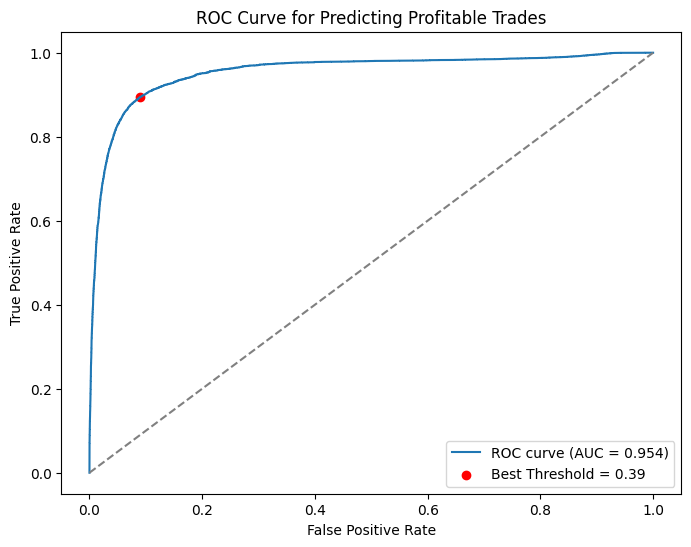

In [101]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting Profitable Trades')
plt.legend()
plt.show()
plt.savefig(os.path.join(output_dir, "ROC_Curve_Profitability"), dpi=300, bbox_inches='tight')
plt.close()


In [102]:
def predict_if_profitable(trade_dict, ttr_model, profit_threshold=best_threshold):

    trade_df = pd.DataFrame([trade_dict])

    predicted_pnl = ttr_model.predict(trade_df)[0]

    # Determine if likely profitable
    likely_profitable = predicted_pnl > profit_threshold

    return likely_profitable


In [103]:
preds = []
actuals = []

for i in range(20):
    sample_dict = X_test.iloc[i].to_dict()
    pred = predict_if_profitable(sample_dict, ttr_model=ttr)
    preds.append(int(pred))  # convert True/False to 1/0
    actuals.append(int(y_test.iloc[i] > 0))

# Build DataFrame
df_results = pd.DataFrame({
    'Predicted_Profit': preds,
    'Actual_Profit': actuals
})


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = df_results['Predicted_Profit']
y_true = df_results['Actual_Profit']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.95

Confusion Matrix:
 [[15  1]
 [ 0  4]]


# Testing performance for classifying as profitable or not

In [105]:
y_pred = ttr.predict(X_test)

profit_threshold = best_threshold

y_pred_binary = (y_pred > profit_threshold).astype(int)
y_true_binary = (y_test > 0).astype(int)

# Build DataFrame
df_results = pd.DataFrame({
    'Predicted_Profit': y_pred_binary,
    'Actual_Profit': y_true_binary
})

In [106]:
print("Accuracy:", accuracy_score(y_true_binary, y_pred_binary))
print("Precision:", precision_score(y_true_binary, y_pred_binary))
print("Recall:", recall_score(y_true_binary, y_pred_binary))
print("F1 Score:", f1_score(y_true_binary, y_pred_binary))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_binary, y_pred_binary))

Accuracy: 0.9037023009184736
Precision: 0.8744240925946736
Recall: 0.8946309496435962
F1 Score: 0.88441211570154

Confusion Matrix:
 [[22613  2235]
 [ 1833 15563]]
